# Heizdraht Anemometer CTA/CCA

In [338]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from math import floor, ceil, log10
import pandas as pd
import codecs

# https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
# https://stackoverflow.com/questions/23207055/rounding-errors-to-1-significant-figure-and-round-values-according-to-number-of
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(np.abs(x)))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(np.abs(x))))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

rtn = round_to_n
rtr = round_to_reference

# Fit
def Kings_Law (x, const, m, B):
    y = const + m * (x-B)**4
    return y

def Kings_Law_8 (x, const, m):
    y = const + m * (x-8)**4
    return y
def Kings_Law_10 (x, const, m):
    y = const + m * (x-10)**4
    return y
def Kings_Law_12 (x, const, m):
    y = const + m * (x-12)**4
    return y

# Returns flow velocity and uncertainty
def U_Düse_in_v(U):
    return (U*4.749, U*0.031)

label_size = 20
plt.rcParams.update({'font.size': label_size, 'legend.title_fontsize': 18, 'legend.fontsize': 18, "axes.labelsize": label_size, "xtick.labelsize": label_size, 
"ytick.labelsize": label_size, "axes.labelpad": 4, "lines.markersize": 10, "lines.linewidth": 2})

### CTA Kalibrierung


U=8: const, m, B
1.16 +/- 0.55, 1.1E-02 +/- 0.0032, 9.13 +/- 0.47

U=10: const, m, B
1.23 +/- 0.19, 5.8E-04 +/- 7.9e-05, 7.61 +/- 0.43

U=12: const, m, B
0.19 +/- 0.63, 2.0E-04 +/- 7.5e-05, 4.5 +/- 1.6


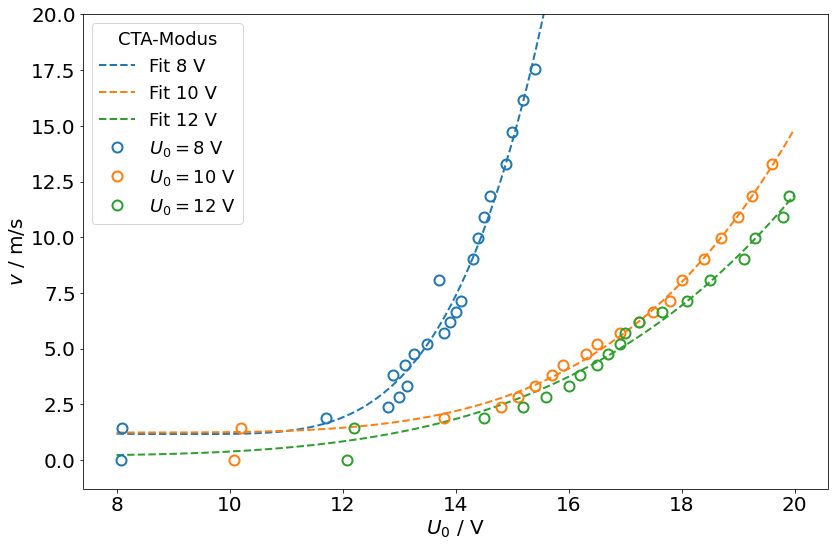

In [339]:
U = np.array([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.1, 3.4, 3.7])
(v, delta_v) = U_Düse_in_v(U)
U_0_8 = np.array([8.08, 8.1, 11.7, 12.8, 13, 13.14, 12.9, 13.1, 13.26, 13.5, 13.8, 13.9, 14, 14.1, 13.7, 14.3, 14.4, 14.5, 14.6, 14.9, 15, 15.2, 15.4])
U_0_10 = np.array([10.07, 10.2, 13.8, 14.8, 15.1, 15.4, 15.7, 15.9, 16.3, 16.5, 16.9, 17.25, 17.5, 17.8, 18, 18.4, 18.7, 19, 19.25, 19.6])
U_0_12 = np.array([12.07, 12.2, 14.5, 15.2, 15.6, 16, 16.2, 16.5, 16.7, 16.9, 17, 17.25, 17.65, 18.1, 18.5, 19.1, 19.3, 19.8, 19.9])
U_total = np.arange(8,16,0.01)


fig, ax = plt.subplots(1,1,figsize=(12,8))
const_vec, m_vec, B_vec = [], [], []
delta_const_vec, delta_m_vec, delta_B_vec = [], [], []

for i, (data, VOLT) in enumerate(zip([U_0_8, U_0_10, U_0_12], [8, 10, 12])):
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)

    guess = [0, 1, VOLT]
    parameters, covariance = curve_fit(Kings_Law, data[1:], v[1:len(data)], p0=guess)
    std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(8, ceil(data[-1]), 0.01)        
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    ((const, m, B), (delta_const, delta_m, delta_B)) = rtr(parameters, std_error, 2)
    print(f"{const} +/- {delta_const}, {m:.1E} +/- {delta_m}, {B} +/- {delta_B}")
    const_vec.append(const), m_vec.append(f"{m:.1E}"), B_vec.append(B), delta_const_vec.append(delta_const), delta_m_vec.append(f"{delta_m:.1E}"), delta_B_vec.append(delta_B)

    label=f"Fit {VOLT} V"
    # label=f"$v(U_0)=({{{const}}} \\frac{{m}}{{s}} + {{{m:.1E}}})\ \\cdot (U_0 - {{{B}}} V) \\frac{{m}}{{sV^4}}$"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_0$ / V")
ax.set_ylim(top=20)
ax.legend(title="CTA-Modus")
plt.tight_layout()
plt.savefig("Abb/Heizdraht_3_2_CTA.png")

### Fit-Parameter Daten

In [340]:
U_0 = [8, 10, 12]
data_dict = {"$U_0 / \mathrm{V}$": U_0, "$\mathrm{const} / \\frac{m}{s}$": const_vec, "$\Delta \mathrm{const} / \\frac{m}{s}$": delta_const_vec,
             "$m / \\frac{m}{sV^4}$": m_vec,  "$\Delta m / \\frac{m}{sV^4}$": delta_m_vec,  "$B / \mathrm{V}$": B_vec, "$\Delta B / \mathrm{V}$": delta_B_vec,
}
# From index because columns are not the same size: First orient in rows, so only columns are missing, which in no problem and then transpose the dataframe
df = pd.DataFrame.from_dict(data = data_dict, orient="index").transpose()

caption = r"Parameter und Fehler für den Fit in Abb. \ref{fig:Heizdraht_CTA} mit Gl. (\ref{eq:Kings_Law}) im CTA Modus."
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA", caption=caption))
with codecs.open("Tabellen/Heizdraht_CTA_Fit_Parameter.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA_Fit_Parameter", caption=caption, na_rep=""))

\begin{table}
\centering
\caption{???}
\label{tab:Heizdraht_CTA}
\begin{tabular}{lllllll}
\toprule
$U_0 / \mathrm{V}$ & $\mathrm{const} / \frac{m}{s}$ & $\Delta \mathrm{const} / \frac{m}{s}$ & $m / \frac{m}{sV^4}$ & $\Delta m / \frac{m}{sV^4}$ & $B / \mathrm{V}$ & $\Delta B / \mathrm{V}$ \\
\midrule
                 8 &                           1.16 &                                  0.55 &              1.1E-02 &                     3.2E-03 &             9.13 &                    0.47 \\
                10 &                           1.23 &                                  0.19 &              5.8E-04 &                     7.9E-05 &             7.61 &                    0.43 \\
                12 &                           0.19 &                                  0.63 &              2.0E-04 &                     7.5E-05 &              4.5 &                     1.6 \\
\bottomrule
\end{tabular}
\end{table}



### Fest


U=8: const, m, B
0.057, 5.9E-03, 8

U=10: const, m, B
2.2, 1.4E-03, 10

U=12: const, m, B
3.1, 2.4E-03, 12


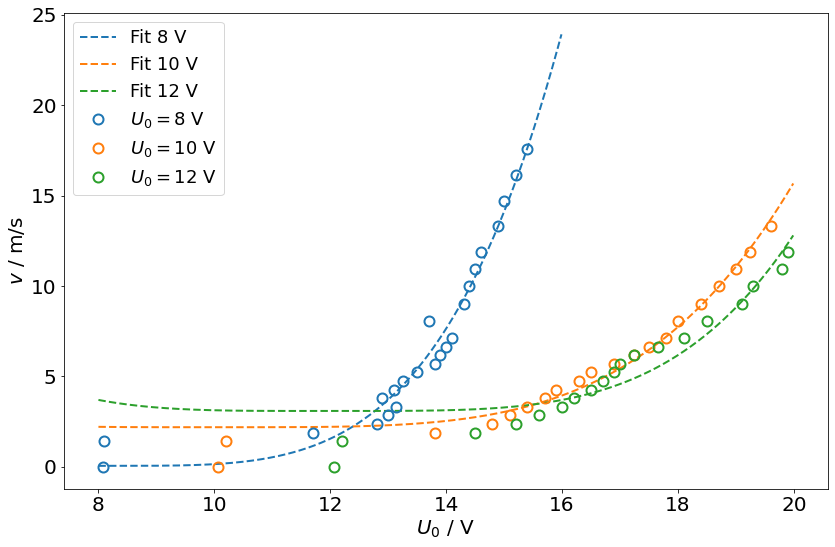

In [341]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
for i, (data, VOLT, Kings_Law_i) in enumerate(zip([U_0_8, U_0_10, U_0_12], [8, 10, 12], [Kings_Law_8, Kings_Law_10, Kings_Law_12])):
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)

    guess = [0, 1]
    parameters, covariance = curve_fit(Kings_Law_i, data[1:], v[1:len(data)], p0=guess)
    std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(8, ceil(data[-1]), 0.01)        
    fit_y = Kings_Law_i(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    (const, m) = rtn(parameters, 2)
    print(f"{const}, {m:.1E}, {VOLT}")

    label=f"Fit {VOLT} V"
    # label=f"$v(U_0)=({{{const}}} \\frac{{m}}{{s}} + {{{m:.1E}}})\ \\cdot (U_0 - {{{B}}} V) \\frac{{m}}{{sV^4}}$"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_0$ / V")
ax.legend()
plt.tight_layout()
# plt.savefig("Abb/Heizdraht_3_2_CTA_B_fest.png")

### Moved


U=8: const, m, B
1.2, 1.1E-02, 1.1

U=10: const, m, B
1.2, 5.8E-04, -2.5

U=12: const, m, B
0.19, 2.0E-04, -7.6


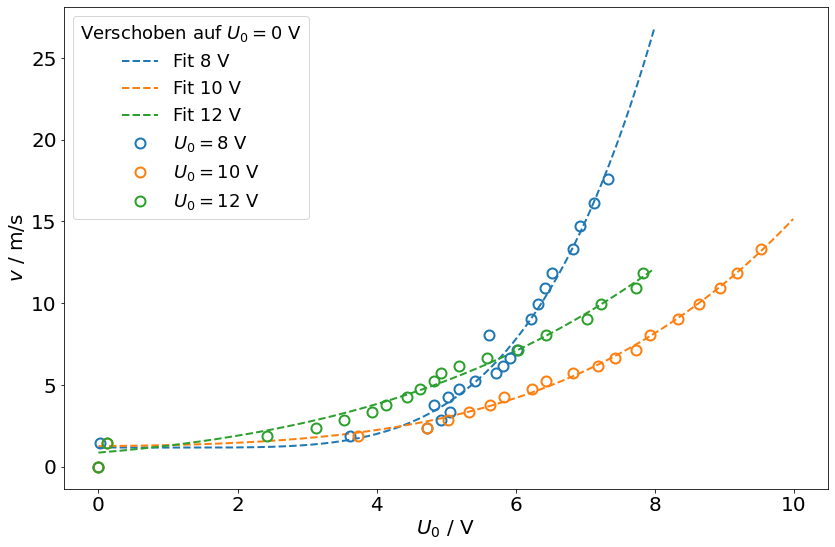

In [342]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
for i, (data, VOLT) in enumerate(zip([U_0_8, U_0_10, U_0_12], [8, 10, 12])):
    data = data-data[0]
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
    guess = [0, 1, 0]
    parameters, covariance = curve_fit(Kings_Law, data[1:], v[1:len(data)], p0=guess)
    # std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(0, ceil(data[-1]), 0.01)        
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    (const, m, B) = rtn(parameters, 2)
    print(f"{const}, {m:.1E}, {B}")
    # print(*parameters)

    label=f"Fit {VOLT} V"
    # (const, m, B) = rtn(parameters, 2)
    # label=f"$v(U_0)=({{{const}}} \\frac{{m}}{{s}} + {{{m:.1E}}})\ \\cdot (U_0 - {{{B}}} V) \\frac{{m}}{{sV^4}}$"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_0$ / V")
ax.legend(title="Verschoben auf $U_0 = 0$ V")
plt.tight_layout()
# plt.savefig("Abb/Heizdraht_3_2_CTA_Verschoben.png")

### Messdaten CTA

In [343]:
data_dict = {"$U / \mathrm{V}$": U, "$U_{0,8} / \mathrm{V}$": U_0_8, "$U_{0,10} / \mathrm{V}$": U_0_10, "$U_{0,12} / \mathrm{V}$": U_0_12}
# From index because columns are not the same size: First orient in rows, so only columns are missing, which in no problem and then transpose the dataframe
df = pd.DataFrame.from_dict(data = data_dict, orient="index").transpose()
caption = r"Messdaten zum im CTA-Modus betriebenen ISA Chrom 60 Heizdraht-Anemometer aus Kap. \ref{Kap:Heizdraht-Anemometer}. Änderung der Versorgespannung $U_0$ für verschiedene Ausgangsspannungen $U_{0,8}=\SI{8}{V},U_{0,10}=\SI{10}{V}$ und $U_{0,12}=\SI{12}{V}$ bei der Düsenspannung $U$, um die Schaltung abzugleichen. Aufgrund der maximalen Spannungsversorgung können für einige Spannungen $U$ die Versorgespannungen $U_0$ nicht weiter erhöht werden."
# caption = r"???"
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA", caption=caption))
with codecs.open("Tabellen/Heizdraht_CTA.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA", caption=caption, na_rep=""))

\begin{table}
\centering
\caption{???}
\label{tab:Heizdraht_CTA}
\begin{tabular}{rrrr}
\toprule
 $U / \mathrm{V}$ &  $U_{0,8} / \mathrm{V}$ &  $U_{0,10} / \mathrm{V}$ &  $U_{0,12} / \mathrm{V}$ \\
\midrule
              0.0 &                    8.08 &                    10.07 &                    12.07 \\
              0.3 &                    8.10 &                    10.20 &                    12.20 \\
              0.4 &                   11.70 &                    13.80 &                    14.50 \\
              0.5 &                   12.80 &                    14.80 &                    15.20 \\
              0.6 &                   13.00 &                    15.10 &                    15.60 \\
              0.7 &                   13.14 &                    15.40 &                    16.00 \\
              0.8 &                   12.90 &                    15.70 &                    16.20 \\
              0.9 &                   13.10 &                    15.90 &               

### CCA Modus


U=12: const, m, B
2.22 +/- 0.26, 2.7E-01 +/- 0.056, -3.33 +/- 0.14


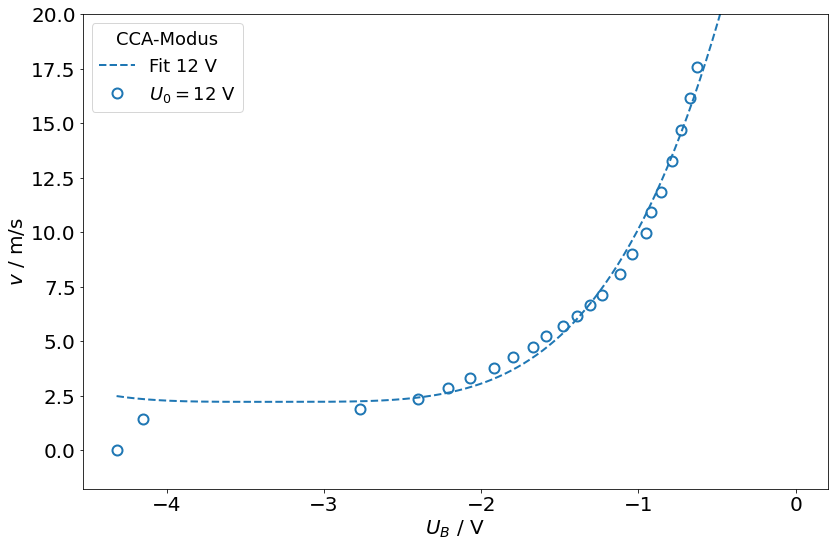

In [344]:
U = np.array([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.1, 3.4, 3.7])
(v, delta_v) = U_Düse_in_v(U)
U_B = np.array([4.32, 4.15, 2.77, 2.4, 2.21, 2.07, 1.92, 1.8, 1.67, 1.59, 1.48, 1.39, 1.31, 1.23, 1.12, 1.04, 0.95, 0.92, 0.86, 0.79, 0.73, 0.67, 0.63])*(-1)
U_total = np.arange(-4.5, -0.5, 0.01)

fig, ax = plt.subplots(1,1, figsize=(12,8))

const_vec, m_vec, B_vec = [], [], []
delta_const_vec, delta_m_vec, delta_B_vec = [], [], []

for i, (data, VOLT) in enumerate(zip([U_B], [12])):
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)

    guess = [2, 1, -3]
    parameters, covariance = curve_fit(Kings_Law, data[1:], v[1:len(data)], p0=guess)
    std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(data[0], ceil(data[-1]), 0.01)        
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    ((const, m, B), (delta_const, delta_m, delta_B)) = rtr(parameters, std_error, 2)
    print(f"{const} +/- {delta_const}, {m:.1E} +/- {delta_m}, {B} +/- {delta_B}")
    const_vec.append(const), m_vec.append(f"{m:.1E}"), B_vec.append(B), delta_const_vec.append(delta_const), delta_m_vec.append(f"{delta_m:.1E}"), delta_B_vec.append(delta_B)

    label=f"Fit {VOLT} V"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)

label="Fit"
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_B$ / V")
ax.set_ylim(top=20)
ax.legend(title="CCA-Modus")
plt.tight_layout()
# plt.savefig("Abb/Heizdraht_3_2_CCA_alleine.png")

# Zwei einzelne Kurven fitten


U=12[1..23]: const, m, B
2.22 +/- 0.26, 2.7E-01 +/- 0.056, -3.33 +/- 0.14

U=12[1..11]: const, m, B
1.398 +/- 0.056, 4.8E-02 +/- 0.0055, -4.574 +/- 0.092


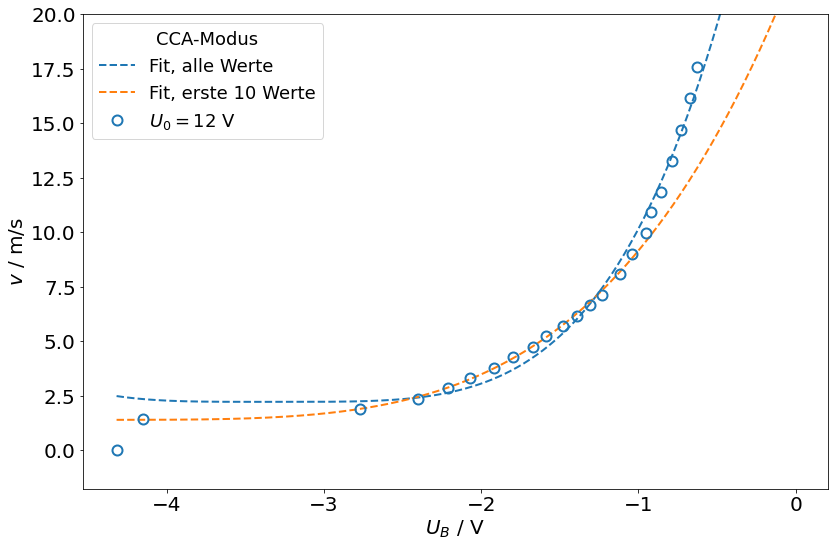

In [345]:
U = np.array([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.1, 3.4, 3.7])
(v, delta_v) = U_Düse_in_v(U)
U_B = np.array([4.32, 4.15, 2.77, 2.4, 2.21, 2.07, 1.92, 1.8, 1.67, 1.59, 1.48, 1.39, 1.31, 1.23, 1.12, 1.04, 0.95, 0.92, 0.86, 0.79, 0.73, 0.67, 0.63])*(-1)
U_total = np.arange(-4.5, -0.5, 0.01)

fig, ax = plt.subplots(1,1, figsize=(12,8))

const_vec, m_vec, B_vec = [], [], []
delta_const_vec, delta_m_vec, delta_B_vec = [], [], []

for i, (data, VOLT, b, e) in enumerate(zip([U_B, U_B], [12, 12], [1,1], [23,11])):
    if i == 0: ax.errorbar(data, v[0:len(data)], zorder=3, label =f"$U_0 = {VOLT}$ V", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)

    guess = [2, 1, -3]
    parameters, covariance = curve_fit(Kings_Law, data[b:e], v[b:e], p0=guess)
    std_error = np.sqrt(np.diag(covariance))
    U_total = np.arange(data[0], ceil(data[-1]), 0.01)        
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}[{b}..{e}]: const, m, B")
    ((const, m, B), (delta_const, delta_m, delta_B)) = rtr(parameters, std_error, 2)
    print(f"{const} +/- {delta_const}, {m:.1E} +/- {delta_m}, {B} +/- {delta_B}")
    const_vec.append(const), m_vec.append(f"{m:.1E}"), B_vec.append(B), delta_const_vec.append(delta_const), delta_m_vec.append(f"{delta_m:.1E}"), delta_B_vec.append(delta_B)

    if i == 0: label = f"Fit, alle Werte"
    if i == 1: label = f"Fit, erste 10 Werte"

    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)

label="Fit"
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_B$ / V")
ax.set_ylim(top=20)
ax.legend(title="CCA-Modus")
plt.tight_layout()
plt.savefig("Abb/Heizdraht_3_2_CCA.png")

In [346]:
U_0 = ["12, alle Werte", "12, erste 10 Werte"]
data_dict = {"$U_0 / \mathrm{V}$": U_0, "$\mathrm{const} / \\frac{m}{s}$": const_vec, "$\Delta \mathrm{const} / \\frac{m}{s}$": delta_const_vec,
             "$m / \\frac{m}{sV^4}$": m_vec,  "$\Delta m / \\frac{m}{sV^4}$": delta_m_vec,  "$B / \mathrm{V}$": B_vec, "$\Delta B / \mathrm{V}$": delta_B_vec,
}
# From index because columns are not the same size: First orient in rows, so only columns are missing, which in no problem and then transpose the dataframe
df = pd.DataFrame.from_dict(data = data_dict, orient="index").transpose()

caption = r"Parameter und Fehler für den Fit in Abb. \ref{fig:Heizdraht_CCA} mit Gl. (\ref{eq:Kings_Law}) im CCA Modus."
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CCA", caption=caption))
with codecs.open("Tabellen/Heizdraht_CCA_Fit_Parameter.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CCA_Fit_Parameter", caption=caption, na_rep=""))

\begin{table}
\centering
\caption{???}
\label{tab:Heizdraht_CCA}
\begin{tabular}{lllllll}
\toprule
 $U_0 / \mathrm{V}$ & $\mathrm{const} / \frac{m}{s}$ & $\Delta \mathrm{const} / \frac{m}{s}$ & $m / \frac{m}{sV^4}$ & $\Delta m / \frac{m}{sV^4}$ & $B / \mathrm{V}$ & $\Delta B / \mathrm{V}$ \\
\midrule
     12, alle Werte &                           2.22 &                                  0.26 &              2.7E-01 &                     5.6E-02 &            -3.33 &                    0.14 \\
 12, erste 10 Werte &                          1.398 &                                 0.056 &              4.8E-02 &                     5.5E-03 &           -4.574 &                   0.092 \\
\bottomrule
\end{tabular}
\end{table}



### Alle Daten

In [347]:
data_dict = {"$U / \mathrm{V}$": U, "$U_{0,8} / \mathrm{V}$": U_0_8, "$U_{0,10} / \mathrm{V}$": U_0_10, "$U_{0,12} / \mathrm{V}$": U_0_12, "$U_B / \mathrm{V}$": U_B}
# From index because columns are not the same size: First orient in rows, so only columns are missing, which in no problem and then transpose the dataframe
df = pd.DataFrame.from_dict(data = data_dict, orient="index").transpose()
caption = r"Messdaten für den ISA Chrom 60 Heizdraht aus Kap. \ref{Kap:Heizdraht-Anemometer}. Links: CTA Modus, Änderung der Versorgespannung $U_0$ für verschiedene Ausgangsspannungen $U_{0,8}=\SI{8}{V},U_{0,10}=\SI{10}{V}$ und $U_{0,12}=\SI{12}{V}$ bei der Düsenspannung $U$, um die Schaltung abzugleichen. Rechts: CCA Modus, Messung der verstärkten Brückenspannung $U_B$ bei konstanter Versorgespannung $U_0=\SI{12}{V}$."
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA_CCA", caption=caption))
with codecs.open("Tabellen/Heizdraht_CTA_CCA.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA_CCA", caption=caption, na_rep=""))

\begin{table}
\centering
\caption{Messdaten für den ISA Chrom 60 Heizdraht aus Kap. \ref{Kap:Heizdraht-Anemometer}. Links: CTA Modus, Änderung der Versorgespannung $U_0$ für verschiedene Ausgangsspannungen $U_{0,8}=\SI{8}{V},U_{0,10}=\SI{10}{V}$ und $U_{0,12}=\SI{12}{V}$ bei der Düsenspannung $U$, um die Schaltung abzugleichen. Rechts: CCA Modus, Messung der verstärkten Brückenspannung $U_B$ bei konstanter Versorgespannung $U_0=\SI{12}{V}$.}
\label{tab:Heizdraht_CTA_CCA}
\begin{tabular}{rrrrr}
\toprule
 $U / \mathrm{V}$ &  $U_{0,8} / \mathrm{V}$ &  $U_{0,10} / \mathrm{V}$ &  $U_{0,12} / \mathrm{V}$ &  $U_B / \mathrm{V}$ \\
\midrule
              0.0 &                    8.08 &                    10.07 &                    12.07 &               -4.32 \\
              0.3 &                    8.10 &                    10.20 &                    12.20 &               -4.15 \\
              0.4 &                   11.70 &                    13.80 &                    14.50 &               

### Vergleich CTA CCA


U=12: const, m, B
0.19 +/- 0.63, 3.2E+01 +/- 12.0, 0.227 +/- 0.079

U=12: const, m, B
2.22 +/- 0.26, 5.0E+01 +/- 10.0, 0.269 +/- 0.038


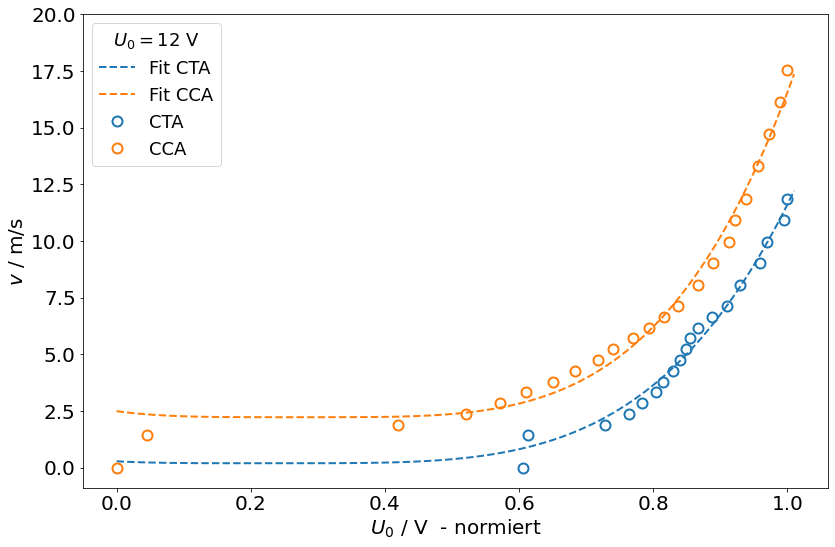

In [360]:
U = np.array([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3.1, 3.4, 3.7])
(v, delta_v) = U_Düse_in_v(U)
U_0_12_norm = U_0_12/np.max(U_0_12) 
# U_B_norm = -U_B/(-np.max(U_0_12)) 

# U_0_12_norm = (U_0_12-U_0_12[0])/np.max(U_0_12-U_0_12[0]) 
U_B_norm = (U_B-U_B[0])/np.max(U_B-U_B[0])
# U_B_norm = (U_B)/np.max(U_B)

# U_B_norm = (U_B+10)/np.max(U_B+10)


# U_B_norm = np.abs(U_B)/np.max(np.abs(U_B))
U_total = np.arange(0, 1.02, 0.01)        

fig, ax = plt.subplots(1,1,figsize=(12,8))
const_vec, m_vec, B_vec = [], [], []
delta_const_vec, delta_m_vec, delta_B_vec = [], [], []

for i, (data, modus) in enumerate(zip([U_0_12_norm, U_B_norm], ["CTA", "CCA"])):
    ax.errorbar(data, v[0:len(data)], zorder=3, label =f"{modus}", c=f"C{i}", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)

    guess = [0, 1, 0]
    parameters, covariance = curve_fit(Kings_Law, data[1:], v[1:len(data)], p0=guess)
    std_error = np.sqrt(np.diag(covariance))
    fit_y = Kings_Law(U_total, *parameters)

    print(f"\nU={VOLT}: const, m, B")
    ((const, m, B), (delta_const, delta_m, delta_B)) = rtr(parameters, std_error, 2)
    print(f"{const} +/- {delta_const}, {m:.1E} +/- {delta_m}, {B} +/- {delta_B}")
    const_vec.append(const), m_vec.append(f"{m:.1E}"), B_vec.append(B), delta_const_vec.append(delta_const), delta_m_vec.append(f"{delta_m:.1E}"), delta_B_vec.append(delta_B)

    label=f"Fit {modus}"
    # label=f"$v(U_0)=({{{const}}} \\frac{{m}}{{s}} + {{{m:.1E}}})\ \\cdot (U_0 - {{{B}}} V) \\frac{{m}}{{sV^4}}$"
    ax.plot(U_total, fit_y, ls = "--", c=f"C{i}", label=label, zorder=2)
ax.set_ylabel("$v$ / m/s")
ax.set_xlabel("$U_0$ / V  - normiert")
ax.set_ylim(top=20)
ax.legend(title="$U_0 = 12$ V")
plt.tight_layout()
plt.savefig("Abb/Heizdraht_3_2_CTA_CCA_Vergleich.png")

In [359]:
U_B

array([-4.32, -4.15, -2.77, -2.4 , -2.21, -2.07, -1.92, -1.8 , -1.67,
       -1.59, -1.48, -1.39, -1.31, -1.23, -1.12, -1.04, -0.95, -0.92,
       -0.86, -0.79, -0.73, -0.67, -0.63])

In [351]:
U_0 = ["CTA", "CCA"]
data_dict = {"$U_0 / \mathrm{V}$": U_0, "$\mathrm{const} / \\frac{m}{s}$": const_vec, "$\Delta \mathrm{const} / \\frac{m}{s}$": delta_const_vec,
             "$m / \\frac{m}{sV^4}$": m_vec,  "$\Delta m / \\frac{m}{sV^4}$": delta_m_vec,  "$B / \mathrm{V}$": B_vec, "$\Delta B / \mathrm{V}$": delta_B_vec,
}
# From index because columns are not the same size: First orient in rows, so only columns are missing, which in no problem and then transpose the dataframe
df = pd.DataFrame.from_dict(data = data_dict, orient="index").transpose()

caption = r"Vergleich der Fitparameter für Gl. (\ref{eq:Kings_Law}) für die normierten Spannungen im CTA und CCA Modus."
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA_CCA_norm_Fit_Parameter", caption=caption))
with codecs.open("Tabellen/Heizdraht_CTA_CCA_norm_Fit_Parameter.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_CTA_CCA_norm_Fit_Parameter", caption=caption, na_rep=""))

\begin{table}
\centering
\caption{???}
\label{tab:Heizdraht_CTA_CCA_norm_Fit_Parameter}
\begin{tabular}{lllllll}
\toprule
$U_0 / \mathrm{V}$ & $\mathrm{const} / \frac{m}{s}$ & $\Delta \mathrm{const} / \frac{m}{s}$ & $m / \frac{m}{sV^4}$ & $\Delta m / \frac{m}{sV^4}$ & $B / \mathrm{V}$ & $\Delta B / \mathrm{V}$ \\
\midrule
               CTA &                           0.19 &                                  0.63 &              3.2E+01 &                     1.2E+01 &            0.227 &                   0.079 \\
               CCA &                           2.22 &                                  0.26 &              5.0E+01 &                     1.0E+01 &            0.269 &                   0.038 \\
\bottomrule
\end{tabular}
\end{table}



In [350]:
U_B_norm

array([0.        , 0.04607046, 0.4200542 , 0.5203252 , 0.57181572,
       0.6097561 , 0.6504065 , 0.68292683, 0.71815718, 0.7398374 ,
       0.7696477 , 0.79403794, 0.81571816, 0.83739837, 0.86720867,
       0.88888889, 0.91327913, 0.92140921, 0.93766938, 0.95663957,
       0.97289973, 0.98915989, 1.        ])